In [1]:
import os
import sys
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [2]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

# Prediction with LinearRegression on logistic numbers

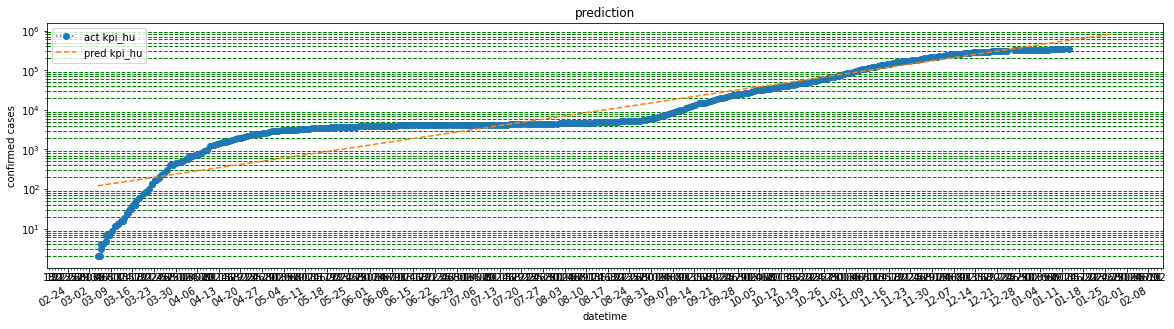

Coefficient of determination: {'kpi_hu': 0.8574059028942317}
Evolution factor per day: {'kpi_hu': 1.1}
Doubling in day(s): {'kpi_hu': 1.8181818181818181}


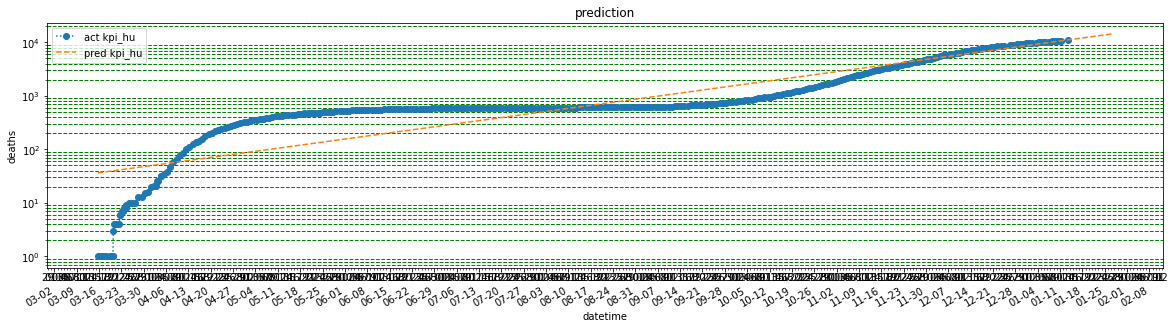

Coefficient of determination: {'kpi_hu': 0.7384722813394804}
Evolution factor per day: {'kpi_hu': 1.0}
Doubling in day(s): {'kpi_hu': 2.0}


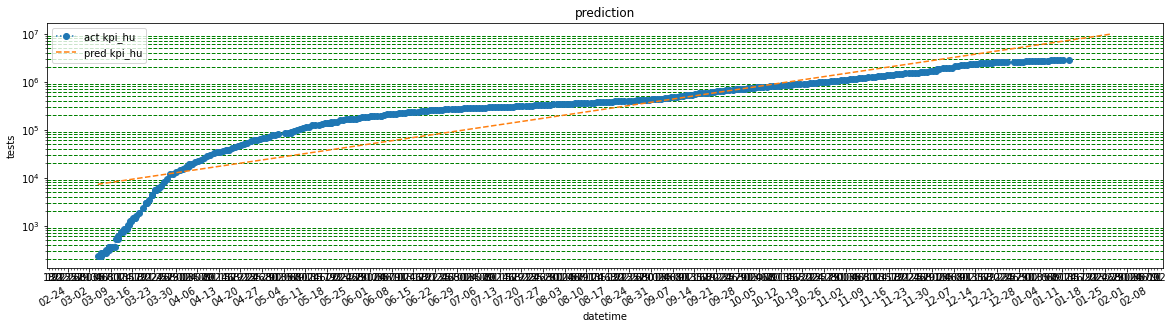

Coefficient of determination: {'kpi_hu': 0.7920158964560858}
Evolution factor per day: {'kpi_hu': 1.1}
Doubling in day(s): {'kpi_hu': 1.8181818181818181}


In [3]:
tmpDf = md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"confirmed cases", "infected")
tmpDf = md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"deaths", "deaths")
tmpDf = md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"tests", "tests")
#md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"recovered cases", "recovered")

In [4]:
from IPython.display import Math
Math(r'log(y) = a*x+b\\ \
     log(y_{2}) - log(y_{1}) = a*(x_{2}-x_{1})\\ \
     10^{log(y_{2}) - log(y_{1})} = 10^{a*(x_{2}-x_{1})}\\ \
     10^{log(y_{2})} / 10^{log(y_{1})} = 10^{a*(x_{2}-x_{1})}\\ \
     y_{2} / y_{1} = 10^{a*(x_{2}-x_{1})}')

<IPython.core.display.Math object>

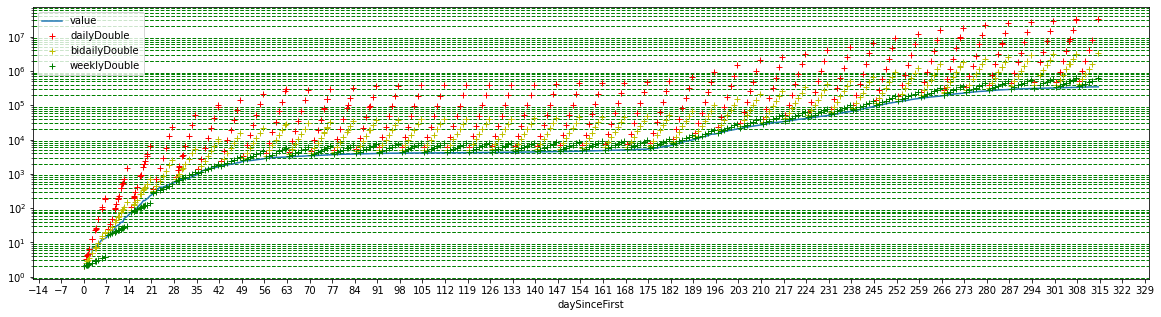

In [5]:
df = merger.show_kpi_hu()[["update","infected"]].copy()
#df = myProcessing.df["HU"][["update","deaths"]].copy()
df.columns = ["date","value"]

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def createDf(df, dayPerPeriod=5):
    # columns ["date","value"]
    df = df[df["value"]>0].copy()
    df["dayInt"] = df["date"].astype(int)/(10**9)/3600/24
    df["cycle"] = df["dayInt"].apply(lambda cell: int((cell - df["dayInt"].min()) / dayPerPeriod))
    df["dayStartOfCycle"] = df["dayInt"].apply(lambda cell: (cell - df["dayInt"].min()) % dayPerPeriod)
    df["valueStartOfCycle"] = df.apply(lambda row: df[df["cycle"]==row["cycle"]]["value"].min(), axis=1)
    df["daySinceFirst"] = df["dayInt"] - df["dayInt"].min()
    df["dailyDouble"] = df["valueStartOfCycle"] * (2**df["dayStartOfCycle"])
    df["bidailyDouble"] = df["valueStartOfCycle"] * (2**(df["dayStartOfCycle"] / 2))
    df["weeklyDouble"] = df["valueStartOfCycle"] * (2**(df["dayStartOfCycle"] / 7))
    del df["date"]
    del df["dayInt"]
    del df["dayStartOfCycle"]
    del df["valueStartOfCycle"]
    del df["cycle"]
    return df
def plotDf(df, dayPerPeriod=5):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_yscale("log")
    ax.grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1)
    ax.grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2)
    ax.xaxis.set_major_locator(MultipleLocator(period))
    df.plot(x="daySinceFirst", y="value", ax=ax)
    df.plot(x="daySinceFirst", y="dailyDouble", ax=ax, style="r+")
    df.plot(x="daySinceFirst", y="bidailyDouble", ax=ax, style="y+")
    df.plot(x="daySinceFirst", y="weeklyDouble", ax=ax, style="g+")
    plt.show()
    
period = 7
df = createDf(df, dayPerPeriod=period)
plotDf(df, dayPerPeriod=period)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
deaths_df = pd.read_json("data/deaths_hu/latest.json")
deaths_df["Nem"] = deaths_df["Nem"].apply(lambda cell: cell[0:1].capitalize() if isinstance(cell, str) else cell)
deaths_df["Korosztaly"] = deaths_df["Kor"] - deaths_df["Kor"] % 10
deaths_df.tail()
deaths_df[deaths_df["Kor"]<50]

,Sorszám,Nem,Kor,Alapbetegségek,Korosztaly
10,10938.0,F,32.0,kóros elhízás,30.0
22,10926.0,N,47.0,cukorbetegség,40.0
29,10919.0,F,46.0,nem ismert alapbetegség,40.0
71,10878.0,F,44.0,nem ismert alapbetegség,40.0
75,10874.0,F,46.0,nem ismert alapbetegség,40.0
...,...,...,...,...,...
11058,106.0,F,46.0,"krónikus veseelégtelenség, szívelégtelenség, p...",40.0
11104,61.0,N,48.0,"krónikus veseelégtelenség, anyagcsere betegség...",40.0
11112,53.0,F,49.0,"magas vérnyomás, anyagcsere betegség",40.0
11159,7.0,F,38.0,"krónikus pancreatitis, alkoholos májkárosodás",30.0


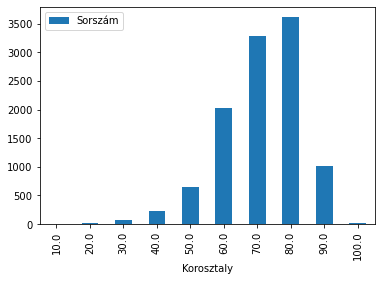

In [7]:
deaths_df.groupby(["Korosztaly"]).agg({"Sorszám":"count"}).plot(kind="bar")
plt.show()

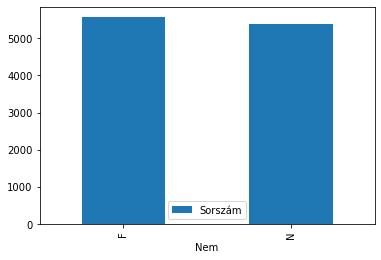

In [8]:
deaths_df.groupby(["Nem"]).agg({"Sorszám":"count"}).plot(kind="bar")
plt.show()

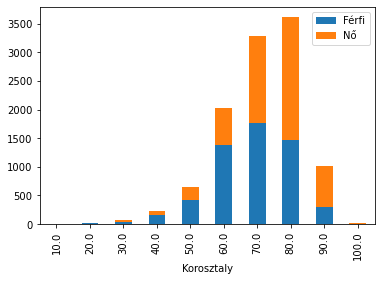

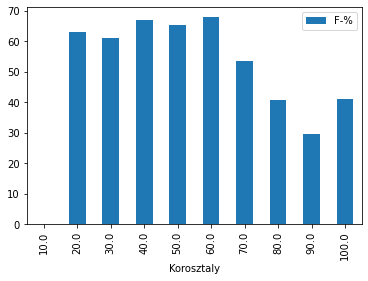

In [9]:
stats_df = deaths_df[deaths_df["Nem"]!=""].groupby(["Korosztaly","Nem"]).agg({"Sorszám":"count"}).unstack('Nem')
columns = ["Férfi","Nő"]
stats_df.columns = columns
stats_df["F-%"] = stats_df["Férfi"]/(stats_df["Férfi"]+stats_df["Nő"])*100
stats_df[columns].plot(kind="bar", stacked=True)
stats_df[["F-%"]].plot(kind="bar")
plt.show()

In [10]:
SIR = merger.show_kpi_hu()[["update","deaths","infected","recovered"]].copy()
SIR.columns = ["date","Deaths","Confirmed","Recovered"]
SIR["I"] = SIR["Confirmed"]-SIR["Deaths"]-SIR["Recovered"]
SIR["RD"] = SIR["Deaths"]+SIR["Recovered"]
SIR["D"] = SIR["Deaths"]
SIR.tail()

,date,Deaths,Confirmed,Recovered,I,RD,D
2021-01-08 09:09:00,2021-01-08 09:09:00,10440.0,337743.0,186449.0,140854.0,196889.0,10440.0
2021-01-09 09:12:00,2021-01-09 09:12:00,10554.0,340459.0,193172.0,136733.0,203726.0,10554.0
2021-01-10 09:23:00,2021-01-10 09:23:00,10648.0,342237.0,197936.0,133653.0,208584.0,10648.0
2021-01-11 08:50:00,2021-01-11 08:50:00,10725.0,343656.0,203972.0,128959.0,214697.0,10725.0
2021-01-13 09:00:00,2021-01-13 09:00:00,10948.0,345710.0,215453.0,119309.0,226401.0,10948.0


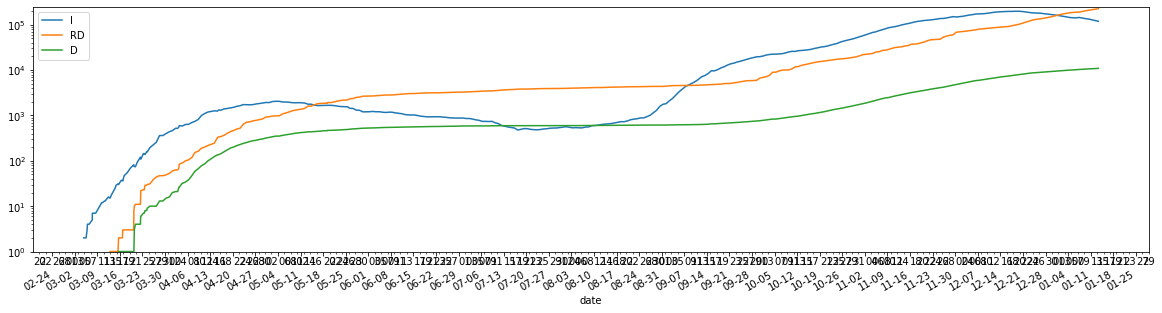

In [11]:
import matplotlib.dates as dates
fig, ax = plt.subplots(figsize=(20,5))

ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=2))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
ax.set_yscale("log")
ax.set_ylim(1, 250000)

SIR.plot(x="date",y=["I","RD","D"],ax=ax)
plt.show()